In [4]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


Bad key "text.kerning_factor" on line 4 in
/Users/jakepohs/opt/anaconda3/envs/PythonData/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [5]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [7]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(autoload_with=engine)

In [9]:
# View all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
measurement = base.classes.measurement
station = base.classes.station

In [13]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
latest_date = session.query(measurement.date).\
                      order_by(measurement.date.desc()).\
                      first()

# Converts latest date to datetime format
latest_date_dt = dt.datetime.strptime(latest_date[0], '%Y-%m-%d').date()
print(latest_date_dt)

2017-08-23


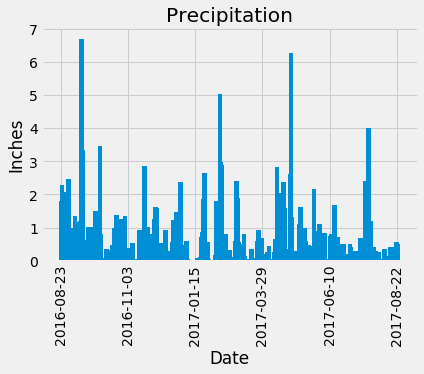

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.

query_date = latest_date_dt - dt.timedelta(weeks = 52.2)
# query_date = dt.date(2016, 8,23)

# Perform a query to retrieve the data and precipitation scores

latest_year_data =  session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= query_date).\
    order_by(measurement.date.desc()).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
latest_year_data_df = pd.DataFrame(latest_year_data, columns=['date', 'precipitation'])

# Sort the dataframe by date
latest_year_data_df = latest_year_data_df.sort_values(by = 'date', ascending= True)

# Use Pandas Plotting with Matplotlib to plot the data
fig1, ax1 = plt.subplots()
plt.bar(latest_year_data_df['date'], latest_year_data_df['precipitation'], width=5)

xticks = np.arange(query_date, latest_date_dt, step = dt.timedelta(weeks = 10.4))
xticks = [pd.to_datetime(tick_day).strftime('%Y-%m-%d') for tick_day in xticks]

ax1.set_xticks(xticks)
ax1.tick_params('x', direction = 'out', labelrotation = 90)
ax1.set_xlabel('Date')
ax1.set_ylabel('Inches')
ax1.set_title("Precipitation")
fig1.tight_layout
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
latest_year_data_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
distinct_station_query = session.query(measurement.station).\
                        distinct().\
                        count()

print(f"There are {distinct_station_query} unique stations in the dataset")

There are 9 unique stations in the dataset


In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_query = session.query(measurement.station, func.count(measurement.station)).\
                        group_by(measurement.station).\
                        order_by(func.count(measurement.station).desc()).\
                        all()
station_query

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active_station_query = session.query(func.min(measurement.tobs), 
                                     func.max(measurement.tobs), 
                                     func.avg(measurement.tobs)).\
                               filter(measurement.station == station_query[0][0]).\
                               all()

active_station_query

[(54.0, 85.0, 71.66378066378067)]

In [15]:
query_date

datetime.date(2016, 8, 23)

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

latest_year_temp =  session.query(measurement.date, measurement.tobs).\
    filter(measurement.station == station_query[0][0]).\
    filter((measurement.date >= query_date)).\
    order_by(measurement.date).\
    all()

latest_year_temp_df = pd.DataFrame(latest_year_temp, columns = ['date','temperature'])
latest_year_temp_df

,date,temperature
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0
...,...,...
347,2017-08-14,77.0
348,2017-08-15,77.0
349,2017-08-16,76.0
350,2017-08-17,76.0


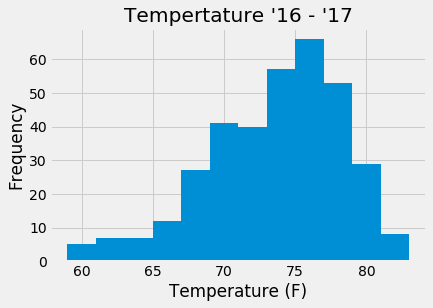

In [17]:
fig2, ax2 = plt.subplots()
plt.hist(latest_year_temp_df['temperature'], bins = 12)

ax2.set_xlabel('Temperature (F)')
ax2.set_ylabel('Frequency')
ax2.set_title("Tempertature '16 - '17")
fig2.tight_layout
plt.show()

# Close Session

In [18]:
# Close Session
session.close()